# Binary Classification

So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"





## Learning Objectives:

After doing this Colab, you'll know how to:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary modules.

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

Unlike some of the previous Colabs, the preceding code cell did not scale the label (`median_house_value`).  The following section ("Normalize values") provides an alternative approach.

## Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should 
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

In [3]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = orign_train_df.mean()
train_df_std = orign_train_df.std()
train_df_norm = (orign_train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10430,-0.4,1.1,-1.2,-0.3,-0.4,-0.5,-0.4,-0.1,-0.5
9175,0.3,-0.6,-0.3,0.3,-0.1,0.0,-0.0,1.2,1.1
11211,-0.7,1.7,-1.5,-0.2,-0.0,-0.4,0.0,-0.9,-0.6
15087,-1.3,0.9,0.7,0.4,0.1,0.2,0.3,0.6,2.0
15338,-1.4,1.1,-1.0,1.1,1.3,1.2,1.3,0.1,-0.3


In [4]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

## Task 1: Create a binary label

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

**Hint:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`. 

In [5]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (orign_train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 


10430   0.0
9175    1.0
11211   0.0
15087   1.0
15338   0.0
         ..
6968    0.0
13505   0.0
16999   0.0
4608    0.0
13587   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [6]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
10430,-0.4,1.1,-1.2,-0.3,-0.4,-0.5,-0.4,-0.1,-0.5,0.0
9175,0.3,-0.6,-0.3,0.3,-0.1,0.0,-0.0,1.2,1.1,1.0
11211,-0.7,1.7,-1.5,-0.2,-0.0,-0.4,0.0,-0.9,-0.6,0.0
15087,-1.3,0.9,0.7,0.4,0.1,0.2,0.3,0.6,2.0,1.0
15338,-1.4,1.1,-1.0,1.1,1.3,1.2,1.3,0.1,-0.3,0.0


In [7]:
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2,1.0
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3,0.0
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6,1.0
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1,1.0
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1,0.0


## Represent features in feature columns

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 

In [8]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = [f for f in list(train_df_norm.columns) if f not in [ "median_house_value", "median_house_value_is_high"]]

print(feature_columns)

# X_train = orign_train_df[feature_columns] 
# Y_train = orign_train_df[["median_house_value"]]

# X_train.head()

DenseFeatures = ["median_income", "total_rooms"]
# feature_columns = DenseFeatures

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Prior exercises used [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) as the [activation function](https://developers.google.com/machine-learning/glossary#activation_function). By contrast, this exercise uses [sigmoid](https://developers.google.com/machine-learning/glossary#sigmoid_function) as the activation function. 

In [9]:
train_df, valid_df = train_test_split(train_df_norm, test_size=0.2)

from sklearn.model_selection import train_test_split

tfm = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

class MyDataset(Dataset):
 
    def __init__(self, df, tfm):
       
        self.transform = tfm
        x=df[feature_columns].values
        y=df[["median_house_value_is_high"]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)    
           

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(train_df, tfm)
valid_ds = MyDataset(valid_df, tfm)
test_ds = MyDataset(test_df_norm, tfm)

In [10]:
learning_rate = 0.001
n_epochs = 30
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)

valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [11]:
from torch import nn
import torch.nn.functional as F

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(8, 1),
                )
        self.s = nn.Sigmoid()
        # self.m = nn.Softmax()
    def forward(self, x):
        out = self.hid(x)
        out = self.s(out)
        # out = self.m(out)
        return out
    
Sequential()    

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
  (s): Sigmoid()
)

In [12]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {train_loss:.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {valid_loss:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/030 ]           train_loss = 0.71355 root_mean_squared_error = 0.71355  |           valid_loss = 0.66088 val_root_mean_squared_error = 0.66088



[ Epoch | 002/030 ]           train_loss = 0.62879 root_mean_squared_error = 0.62879  |           valid_loss = 0.59627 val_root_mean_squared_error = 0.59627



[ Epoch | 003/030 ]           train_loss = 0.57148 root_mean_squared_error = 0.57148  |           valid_loss = 0.54590 val_root_mean_squared_error = 0.54590



[ Epoch | 004/030 ]           train_loss = 0.52541 root_mean_squared_error = 0.52541  |           valid_loss = 0.50461 val_root_mean_squared_error = 0.50461



[ Epoch | 005/030 ]           train_loss = 0.48751 root_mean_squared_error = 0.48751  |           valid_loss = 0.47050 val_root_mean_squared_error = 0.47050



[ Epoch | 006/030 ]           train_loss = 0.45628 root_mean_squared_error = 0.45628  |           valid_loss = 0.44236 val_root_mean_squared_error = 0.44236



[ Epoch | 007/030 ]           train_loss = 0.43067 root_mean_squared_error = 0.43067  |           valid_loss = 0.41929 val_root_mean_squared_error = 0.41929



[ Epoch | 008/030 ]           train_loss = 0.40981 root_mean_squared_error = 0.40981  |           valid_loss = 0.40047 val_root_mean_squared_error = 0.40047



[ Epoch | 009/030 ]           train_loss = 0.39293 root_mean_squared_error = 0.39293  |           valid_loss = 0.38523 val_root_mean_squared_error = 0.38523



[ Epoch | 010/030 ]           train_loss = 0.37938 root_mean_squared_error = 0.37938  |           valid_loss = 0.37296 val_root_mean_squared_error = 0.37296



[ Epoch | 011/030 ]           train_loss = 0.36858 root_mean_squared_error = 0.36858  |           valid_loss = 0.36313 val_root_mean_squared_error = 0.36313



[ Epoch | 012/030 ]           train_loss = 0.36001 root_mean_squared_error = 0.36001  |           valid_loss = 0.35526 val_root_mean_squared_error = 0.35526



[ Epoch | 013/030 ]           train_loss = 0.35321 root_mean_squared_error = 0.35321  |           valid_loss = 0.34893 val_root_mean_squared_error = 0.34893



[ Epoch | 014/030 ]           train_loss = 0.34779 root_mean_squared_error = 0.34779  |           valid_loss = 0.34378 val_root_mean_squared_error = 0.34378



[ Epoch | 015/030 ]           train_loss = 0.34343 root_mean_squared_error = 0.34343  |           valid_loss = 0.33954 val_root_mean_squared_error = 0.33954



[ Epoch | 016/030 ]           train_loss = 0.33987 root_mean_squared_error = 0.33987  |           valid_loss = 0.33599 val_root_mean_squared_error = 0.33599



[ Epoch | 017/030 ]           train_loss = 0.33691 root_mean_squared_error = 0.33691  |           valid_loss = 0.33296 val_root_mean_squared_error = 0.33296



[ Epoch | 018/030 ]           train_loss = 0.33440 root_mean_squared_error = 0.33440  |           valid_loss = 0.33033 val_root_mean_squared_error = 0.33033



[ Epoch | 019/030 ]           train_loss = 0.33222 root_mean_squared_error = 0.33222  |           valid_loss = 0.32801 val_root_mean_squared_error = 0.32801



[ Epoch | 020/030 ]           train_loss = 0.33031 root_mean_squared_error = 0.33031  |           valid_loss = 0.32592 val_root_mean_squared_error = 0.32592



[ Epoch | 021/030 ]           train_loss = 0.32859 root_mean_squared_error = 0.32859  |           valid_loss = 0.32404 val_root_mean_squared_error = 0.32404



[ Epoch | 022/030 ]           train_loss = 0.32703 root_mean_squared_error = 0.32703  |           valid_loss = 0.32231 val_root_mean_squared_error = 0.32231



[ Epoch | 023/030 ]           train_loss = 0.32560 root_mean_squared_error = 0.32560  |           valid_loss = 0.32072 val_root_mean_squared_error = 0.32072



[ Epoch | 024/030 ]           train_loss = 0.32428 root_mean_squared_error = 0.32428  |           valid_loss = 0.31925 val_root_mean_squared_error = 0.31925



[ Epoch | 025/030 ]           train_loss = 0.32305 root_mean_squared_error = 0.32305  |           valid_loss = 0.31788 val_root_mean_squared_error = 0.31788



[ Epoch | 026/030 ]           train_loss = 0.32191 root_mean_squared_error = 0.32191  |           valid_loss = 0.31660 val_root_mean_squared_error = 0.31660



[ Epoch | 027/030 ]           train_loss = 0.32084 root_mean_squared_error = 0.32084  |           valid_loss = 0.31540 val_root_mean_squared_error = 0.31540



[ Epoch | 028/030 ]           train_loss = 0.31984 root_mean_squared_error = 0.31984  |           valid_loss = 0.31428 val_root_mean_squared_error = 0.31428



[ Epoch | 029/030 ]           train_loss = 0.31889 root_mean_squared_error = 0.31889  |           valid_loss = 0.31323 val_root_mean_squared_error = 0.31323



[ Epoch | 030/030 ]           train_loss = 0.31801 root_mean_squared_error = 0.31801  |           valid_loss = 0.31224 val_root_mean_squared_error = 0.31224
Defined the build_model and train_model functions.


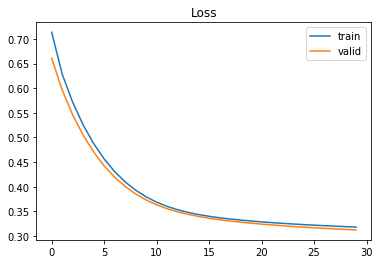

In [13]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

In [14]:
# These are used to record information in validation.
test_loss = []

# Iterate the validation set by batches.
for batch in tqdm(test_loader):
    X, y = batch   
   
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse

    # Record the loss and accuracy.
    test_loss.append(loss.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} root_mean_squared_error = {test_loss:.5f}")


test_loss = 0.32731 root_mean_squared_error = 0.32731


## Task 3: Add precision and recall as metrics

Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model.  Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. We have
added accuracy and precision; your task is to add recall. See the [TensorFlow Reference](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall) for details.



In [15]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

In [19]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred_y = (y_hat > classification_threshold).type(torch.LongTensor)
        
        tp = ((pred_y == y) & (y == 1)).sum()
        tn = ((pred_y == y) & (y == 0)).sum()
        fp = ((pred_y != y) & (y == 1)).sum()
        fn = ((pred_y != y) & (y == 0)).sum()
        
        acc = ((y_hat > classification_threshold)).sum() / X.shape[0]        
        Precision = tp / (tp + fp)
        Recall = tp / (tp + fn)
        
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
      
        # print(acc)
        # print(Precision)
        # print(Recall)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ]           train_loss = 0.75803 valid_loss = 0.69894           Precision = 0.95238 Precision = 0.95238 Recall = 0.20202



[ Epoch | 002/020 ]           train_loss = 0.66395 valid_loss = 0.62770           Precision = 1.00000 Precision = 1.00000 Recall = 0.21212



[ Epoch | 003/020 ]           train_loss = 0.60083 valid_loss = 0.57163           Precision = 1.00000 Precision = 1.00000 Recall = 0.22581



[ Epoch | 004/020 ]           train_loss = 0.54972 valid_loss = 0.52541           Precision = 1.00000 Precision = 1.00000 Recall = 0.27273



[ Epoch | 005/020 ]           train_loss = 0.50742 valid_loss = 0.48710           Precision = 1.00000 Precision = 1.00000 Recall = 0.33871



[ Epoch | 006/020 ]           train_loss = 0.47241 valid_loss = 0.45544           Precision = 0.95238 Precision = 0.95238 Recall = 0.37736



[ Epoch | 007/020 ]           train_loss = 0.44358 valid_loss = 0.42943           Precision = 0.95238 Precision = 0.95238 Recall = 0.40000



[ Epoch | 008/020 ]           train_loss = 0.41999 valid_loss = 0.40817           Precision = 0.95238 Precision = 0.95238 Recall = 0.41667



[ Epoch | 009/020 ]           train_loss = 0.40083 valid_loss = 0.39092           Precision = 0.76190 Precision = 0.76190 Recall = 0.40000



[ Epoch | 010/020 ]           train_loss = 0.38539 valid_loss = 0.37701           Precision = 0.71429 Precision = 0.71429 Recall = 0.41667



[ Epoch | 011/020 ]           train_loss = 0.37303 valid_loss = 0.36587           Precision = 0.71429 Precision = 0.71429 Recall = 0.41667



[ Epoch | 012/020 ]           train_loss = 0.36321 valid_loss = 0.35696           Precision = 0.71429 Precision = 0.71429 Recall = 0.44118



[ Epoch | 013/020 ]           train_loss = 0.35543 valid_loss = 0.34983           Precision = 0.71429 Precision = 0.71429 Recall = 0.45455



[ Epoch | 014/020 ]           train_loss = 0.34926 valid_loss = 0.34410           Precision = 0.71429 Precision = 0.71429 Recall = 0.45455



[ Epoch | 015/020 ]           train_loss = 0.34433 valid_loss = 0.33943           Precision = 0.71429 Precision = 0.71429 Recall = 0.46875



[ Epoch | 016/020 ]           train_loss = 0.34037 valid_loss = 0.33560           Precision = 0.71429 Precision = 0.71429 Recall = 0.46875



[ Epoch | 017/020 ]           train_loss = 0.33714 valid_loss = 0.33240           Precision = 0.71429 Precision = 0.71429 Recall = 0.48387



[ Epoch | 018/020 ]           train_loss = 0.33446 valid_loss = 0.32968           Precision = 0.71429 Precision = 0.71429 Recall = 0.48387



[ Epoch | 019/020 ]           train_loss = 0.33219 valid_loss = 0.32732           Precision = 0.71429 Precision = 0.71429 Recall = 0.48387



[ Epoch | 020/020 ]           train_loss = 0.33024 valid_loss = 0.32524           Precision = 0.71429 Precision = 0.71429 Recall = 0.46875
Defined the build_model and train_model functions.


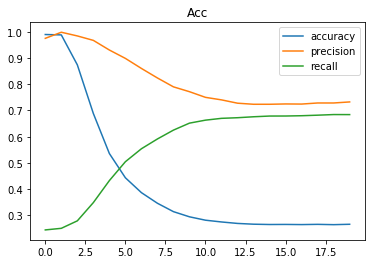

In [20]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_accuracy)
plt.plot(epoch_precision)
plt.plot(epoch_recall)
plt.title('Acc')
plt.legend(['accuracy', "precision", "recall"])
plt.savefig('acc.png')
plt.show()

## Task 4: Experiment with the classification threshold (if time permits)

Experiment with different values for `classification_threshold` in the code cell within "Invoke the creating, training, and plotting functions."  What value of `classification_threshold` produces the highest accuracy?

In [21]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

In [22]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred_y = (y_hat > classification_threshold).type(torch.LongTensor)
        
        tp = ((pred_y == y) & (y == 1)).sum()
        tn = ((pred_y == y) & (y == 0)).sum()
        fp = ((pred_y != y) & (y == 1)).sum()
        fn = ((pred_y != y) & (y == 0)).sum()
        
        acc = ((y_hat > classification_threshold)).sum() / X.shape[0]        
        Precision = tp / (tp + fp)
        Recall = tp / (tp + fn)
        
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
      
        # print(acc)
        # print(Precision)
        # print(Recall)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ]           train_loss = 0.65475 valid_loss = 0.61306           Precision = 0.80952 Precision = 0.80952 Recall = 0.33333



[ Epoch | 002/020 ]           train_loss = 0.58189 valid_loss = 0.55751           Precision = 0.71429 Precision = 0.71429 Recall = 0.35714



[ Epoch | 003/020 ]           train_loss = 0.53358 valid_loss = 0.51450           Precision = 0.66667 Precision = 0.66667 Recall = 0.38889



[ Epoch | 004/020 ]           train_loss = 0.49493 valid_loss = 0.47925           Precision = 0.66667 Precision = 0.66667 Recall = 0.45161



[ Epoch | 005/020 ]           train_loss = 0.46306 valid_loss = 0.44997           Precision = 0.66667 Precision = 0.66667 Recall = 0.50000



[ Epoch | 006/020 ]           train_loss = 0.43665 valid_loss = 0.42565           Precision = 0.66667 Precision = 0.66667 Recall = 0.56000



[ Epoch | 007/020 ]           train_loss = 0.41481 valid_loss = 0.40552           Precision = 0.66667 Precision = 0.66667 Recall = 0.58333



[ Epoch | 008/020 ]           train_loss = 0.39685 valid_loss = 0.38895           Precision = 0.66667 Precision = 0.66667 Recall = 0.58333



[ Epoch | 009/020 ]           train_loss = 0.38220 valid_loss = 0.37540           Precision = 0.66667 Precision = 0.66667 Recall = 0.58333



[ Epoch | 010/020 ]           train_loss = 0.37035 valid_loss = 0.36443           Precision = 0.66667 Precision = 0.66667 Recall = 0.60870



[ Epoch | 011/020 ]           train_loss = 0.36087 valid_loss = 0.35564           Precision = 0.66667 Precision = 0.66667 Recall = 0.63636



[ Epoch | 012/020 ]           train_loss = 0.35338 valid_loss = 0.34867           Precision = 0.61905 Precision = 0.61905 Recall = 0.65000



[ Epoch | 013/020 ]           train_loss = 0.34753 valid_loss = 0.34318           Precision = 0.61905 Precision = 0.61905 Recall = 0.68421



[ Epoch | 014/020 ]           train_loss = 0.34298 valid_loss = 0.33885           Precision = 0.61905 Precision = 0.61905 Recall = 0.68421



[ Epoch | 015/020 ]           train_loss = 0.33943 valid_loss = 0.33537           Precision = 0.61905 Precision = 0.61905 Recall = 0.72222



[ Epoch | 016/020 ]           train_loss = 0.33658 valid_loss = 0.33249           Precision = 0.61905 Precision = 0.61905 Recall = 0.76471



[ Epoch | 017/020 ]           train_loss = 0.33422 valid_loss = 0.33002           Precision = 0.57143 Precision = 0.57143 Recall = 0.75000



[ Epoch | 018/020 ]           train_loss = 0.33219 valid_loss = 0.32785           Precision = 0.57143 Precision = 0.57143 Recall = 0.70588



[ Epoch | 019/020 ]           train_loss = 0.33040 valid_loss = 0.32589           Precision = 0.57143 Precision = 0.57143 Recall = 0.66667



[ Epoch | 020/020 ]           train_loss = 0.32879 valid_loss = 0.32411           Precision = 0.57143 Precision = 0.57143 Recall = 0.66667
Defined the build_model and train_model functions.


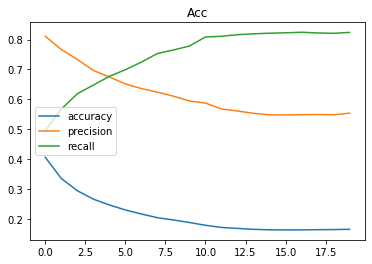

In [23]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_accuracy)
plt.plot(epoch_precision)
plt.plot(epoch_recall)
plt.title('Acc')
plt.legend(['accuracy', "precision", "recall"])
plt.savefig('acc.png')
plt.show()

## Task 5: Summarize model performance (if time permits)

If time permits, add one more metric that attempts to summarize the model's overall performance. 

In [25]:
learning_rate = 0.001
n_epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

In [ ]:
def calcu_AUC(label, pre):
    """
    适用于ｐｙｔｈｏｎ3.0以上版本
    """
    # 计算正样本和负样本的索引，以便索引出之后的概率值
    pos = [i for i in range(len(label)) if label[i] == 1]
    neg = [i for i in range(len(label)) if label[i] == 0]
 
    auc = 0
    for i in pos:
        for j in neg:
            if pre[i] > pre[j]:
                auc += 1
            elif pre[i] == pre[j]:
                auc += 0.5
 
    return auc / (len(pos)*len(neg))

In [45]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.BCELoss()  
    
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
epoch_auc = []
    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())      
                       
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    valid_accuracy = []
    valid_precision = []
    valid_recall = []
    valid_auc = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred_y = (y_hat > classification_threshold).type(torch.LongTensor)
        
        tp = ((pred_y == y) & (y == 1)).sum()
        tn = ((pred_y == y) & (y == 0)).sum()
        fp = ((pred_y != y) & (y == 1)).sum()
        fn = ((pred_y != y) & (y == 0)).sum()
        
        acc = ((y_hat > classification_threshold)).sum() / X.shape[0]        
        Precision = tp / (tp + fp)
        Recall = tp / (tp + fn)
        # tpr = tp / (tp + fn)
        # fpr = fp / (fp + tn)
        
        AUC = calcu_AUC(y, pred_y)
        
        valid_accuracy.append(acc)
        valid_precision.append(Precision)
        valid_recall.append(Recall)
        valid_auc.append(AUC)

        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(valid_loss)
    
    epoch_accuracy.append(sum(valid_accuracy) / len(valid_accuracy))
    epoch_precision.append(sum(valid_precision) / len(valid_precision))
    epoch_recall.append(sum(valid_recall) / len(valid_recall))
    epoch_auc.append(sum(valid_auc) / len(valid_auc))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] train_loss = {train_loss:.5f} valid_loss = {valid_loss:.5f} \
          Precision = {Precision:.5f} Precision = {Precision:.5f} Recall = {Recall:.5f} AUC = {AUC:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/020 ] train_loss = 0.65810 valid_loss = 0.61283           Precision = 0.71429 Precision = 0.71429 Recall = 0.45455 AUC = 0.74322



[ Epoch | 002/020 ] train_loss = 0.58392 valid_loss = 0.55659           Precision = 0.61905 Precision = 0.61905 Recall = 0.52000 AUC = 0.73357



[ Epoch | 003/020 ] train_loss = 0.53414 valid_loss = 0.51277           Precision = 0.57143 Precision = 0.57143 Recall = 0.54545 AUC = 0.72242



[ Epoch | 004/020 ] train_loss = 0.49423 valid_loss = 0.47686           Precision = 0.61905 Precision = 0.61905 Recall = 0.61905 AUC = 0.75889



[ Epoch | 005/020 ] train_loss = 0.46144 valid_loss = 0.44716           Precision = 0.61905 Precision = 0.61905 Recall = 0.65000 AUC = 0.76522



[ Epoch | 006/020 ] train_loss = 0.43443 valid_loss = 0.42267           Precision = 0.61905 Precision = 0.61905 Recall = 0.72222 AUC = 0.77788



[ Epoch | 007/020 ] train_loss = 0.41230 valid_loss = 0.40258           Precision = 0.61905 Precision = 0.61905 Recall = 0.81250 AUC = 0.79054



[ Epoch | 008/020 ] train_loss = 0.39429 valid_loss = 0.38623           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 009/020 ] train_loss = 0.37979 valid_loss = 0.37304           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 010/020 ] train_loss = 0.36822 valid_loss = 0.36251           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 011/020 ] train_loss = 0.35910 valid_loss = 0.35416           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 012/020 ] train_loss = 0.35197 valid_loss = 0.34757           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 013/020 ] train_loss = 0.34641 valid_loss = 0.34234           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 014/020 ] train_loss = 0.34204 valid_loss = 0.33813           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 015/020 ] train_loss = 0.33854 valid_loss = 0.33466           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 016/020 ] train_loss = 0.33567 valid_loss = 0.33172           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 017/020 ] train_loss = 0.33325 valid_loss = 0.32918           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 018/020 ] train_loss = 0.33117 valid_loss = 0.32694           Precision = 0.57143 Precision = 0.57143 Recall = 0.80000 AUC = 0.76673



[ Epoch | 019/020 ] train_loss = 0.32933 valid_loss = 0.32494           Precision = 0.57143 Precision = 0.57143 Recall = 0.70588 AUC = 0.75407



[ Epoch | 020/020 ] train_loss = 0.32768 valid_loss = 0.32312           Precision = 0.61905 Precision = 0.61905 Recall = 0.72222 AUC = 0.77788
Defined the build_model and train_model functions.


findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.


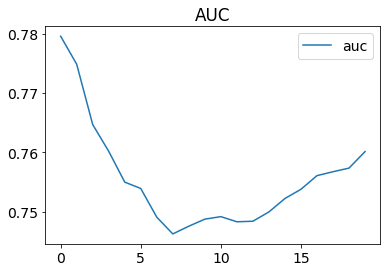

In [46]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_auc)
plt.title('AUC')
plt.legend(['auc'])
plt.savefig('auc.png')
plt.show()